## Ridge Regression

Ridge Regression is a regularized version of Linear Regression that adds an **L2 penalty** to the loss function.

It helps:
- Reduce overfitting
- Handle multicollinearity
- Stabilize coefficient estimates

Ridge is especially useful when predictors are correlated.

## 1) Importing Dependencies and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [5]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [6]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [7]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

## 3) Target Variable Distribution (Medical Insurance Charges)

Text(0.5, 1.0, 'Distribution Of Medical Insurance Charges')

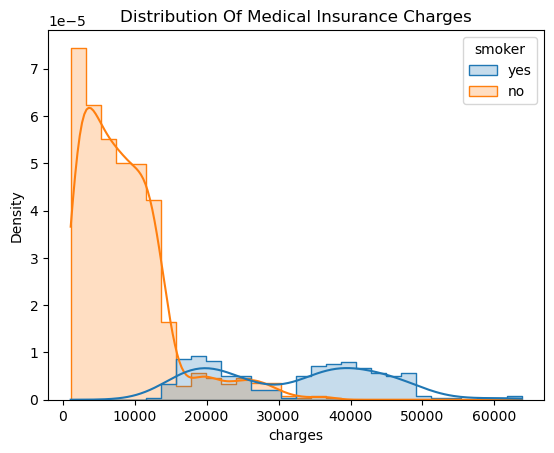

In [8]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution Of Medical Insurance Charges")

The target variable `charges` represents medical insurance costs.  
Its distribution is **right-skewed**, which violates the normality assumption of linear regression.

To stabilize variance and improve model performance, a **log transformation** of the target variable is applied.

In [9]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


Text(0.5, 1.0, 'Log Charges Distribution')

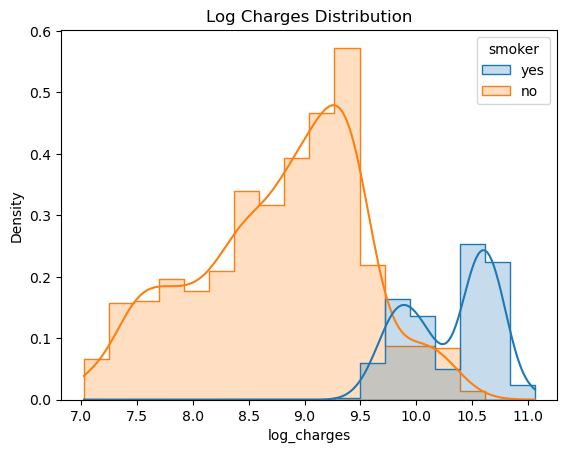

In [10]:
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    stat='density',
    hue='smoker',
    element='step'
)
plt.title("Log Charges Distribution")

## 4) Features and Targets

In [11]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y = df['log_charges']

## 5) Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


### 5(a) Identifying Categorical & Numerical Columns

In [12]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [13]:
print("Categorical Features : ",categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


#### **Numerical & Categorical Features and Target**
- Numerical features : `['age', 'bmi', 'children']`
- Categorical Features : `['sex', 'smoker', 'region']`
- Target : `['log_charges']`

### 5(b) Column Transformer

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ]
)

## 6) Ridge Regression Pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

ridge_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', Ridge(alpha=0.1))
])

## 7) Train-Test-Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

## 8) Model Training

In [17]:
ridge_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9) Model Evaluation
The model is evaluated using:- **R2 Score**: Measures explained variance
- **RMSE**: Measures average prediction error

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred  = ridge_model.predict(X_test)

print(f"Ridge Train R2: {r2_score(y_train, ridge_train_pred):.4f}")
print(f"Ridge Test  R2: {r2_score(y_test, ridge_test_pred):.4f}")
print(f"Ridge Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_test_pred)):.4f}")

Ridge Train R2: 0.7572
Ridge Test  R2: 0.8047
Ridge Test RMSE: 0.4191


## Ridge Hyperparameter Tuning

The regularization parameter `alpha` is tuned using cross-validation 
to find the optimal balance between bias and variance.

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_gs = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring='r2'
)

ridge_gs.fit(X_train, y_train)

,estimator,Pipeline(step...(alpha=0.1))])
,param_grid,"{'regressor__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [20]:
best_ridge = ridge_gs.best_estimator_

best_ridge_test_pred = best_ridge.predict(X_test)

print("Best Ridge Alpha:", ridge_gs.best_params_)
print("Best Ridge Test R2:", r2_score(y_test, best_ridge_test_pred))
print("Best Ridge RMSE:", np.sqrt(mean_squared_error(y_test, best_ridge_test_pred)))


Best Ridge Alpha: {'regressor__alpha': 1}
Best Ridge Test R2: 0.8041749456171201
Best Ridge RMSE: 0.41961204624998255


## Extract Ridge Coefficients

In [21]:
ridge_coefs = best_ridge.named_steps['regressor'].coef_

In [22]:
cat_features = best_ridge.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

feature_names = list(cat_features) + numerical_cols

ridge_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coefs
}).sort_values(by='Coefficient', ascending=False)

ridge_coef_df

,Feature,Coefficient
5,age,1.560333
1,smoker_yes,1.542164
6,bmi,0.489303
7,children,0.456388
2,region_northwest,-0.054823
0,sex_male,-0.073445
4,region_southwest,-0.120160
3,region_southeast,-0.132413
